In [1]:
import pandas as pd
import os
import time
import requests
import unidecode
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import re
tqdm.pandas()

Je commence par récupérer et manipuler les données sur le DPE

In [2]:

# Vérification de la taille du fichier en Mo
file_size = os.path.getsize("dpe-v2-logements-existants.csv") / (1024 * 1024)
print(f"Taille du fichier : {file_size:.2f} Mo")


Taille du fichier : 19008.71 Mo


La taille du fichier étant énorme, je décide de me focaliser sur une seule ville: Abbeville. J'ai téléchargé le fichier directement sur le site en filtrant sur la colonne Nom__commune_ (BAN)

In [3]:

dpe_abbeville = pd.read_csv("dpe-v2-logements-existants-abbeville.csv", sep=",", encoding="utf-8")

display(dpe_abbeville.head())


,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Type_générateur_froid,Surface_climatisée,Type_énergie_climatisation,Catégorie_ENR,Electricité_PV_autoconsommée,Système_production_électricité_origine_renouvelable,Présence_production_PV_(0/1),Production_électricité_PV_(kWhep/an),Surface_totale_capteurs_photovoltaïque,Nombre_module
0,2380E3578091B,2023-10-23,2023-10-22,2023-08-31,DPE 3CL 2021 méthode logement,NaN,2033-10-21,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN
1,2180E0634873H,2021-11-05,2021-11-05,2021-11-04,DPE 3CL 2021 méthode logement,NaN,2031-11-04,1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,Solaire Photovoltaïque,1.0,0.0,NaN,NaN
2,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN
3,2380E2604915F,2023-08-02,2023-07-30,2023-07-30,DPE 3CL 2021 méthode logement,NaN,2033-07-29,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN
4,2380E3578160S,2023-10-23,2023-10-22,2023-08-31,DPE 3CL 2021 méthode logement,NaN,2033-10-21,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN


Je visualise les noms de colonne

In [4]:
dpe_abbeville.columns

Index(['N°DPE', 'Date_réception_DPE', 'Date_établissement_DPE',
       'Date_visite_diagnostiqueur', 'Modèle_DPE', 'N°_DPE_remplacé',
       'Date_fin_validité_DPE', 'Version_DPE', 'N°_DPE_immeuble_associé',
       'Appartement_non_visité_(0/1)',
       ...
       'Type_générateur_froid', 'Surface_climatisée',
       'Type_énergie_climatisation', 'Catégorie_ENR',
       'Electricité_PV_autoconsommée',
       'Système_production_électricité_origine_renouvelable',
       'Présence_production_PV_(0/1)', 'Production_électricité_PV_(kWhep/an)',
       'Surface_totale_capteurs_photovoltaïque', 'Nombre_module'],
      dtype='object', length=242)

In [5]:
for col in dpe_abbeville.columns:
    print(col)

N°DPE
Date_réception_DPE
Date_établissement_DPE
Date_visite_diagnostiqueur
Modèle_DPE
N°_DPE_remplacé
Date_fin_validité_DPE
Version_DPE
N°_DPE_immeuble_associé
Appartement_non_visité_(0/1)
Méthode_application_DPE
N°_immatriculation_copropriété
Invariant_fiscal_logement
N°_RPLS_logement
Etiquette_GES
Etiquette_DPE
Année_construction
Type_bâtiment
Type_installation_chauffage
Type_installation_ECS_(général)
Période_construction
Hauteur_sous-plafond
Nombre_appartement
Nombre_niveau_immeuble
Nombre_niveau_logement
Surface_habitable_immeuble
Surface_habitable_logement
Surface_tertiaire_immeuble
Classe_inertie_bâtiment
Typologie_logement
Position_logement_dans_immeuble
Classe_altitude
Zone_climatique_
Adresse_brute
Nom__commune_(BAN)
Code_INSEE_(BAN)
N°_voie_(BAN)
Identifiant__BAN
Adresse_(BAN)
Code_postal_(BAN)
Score_BAN
Nom__rue_(BAN)
Coordonnée_cartographique_X_(BAN)
Coordonnée_cartographique_Y_(BAN)
Code_postal_(brut)
N°_étage_appartement
Nom_résidence
Complément_d'adresse_bâtiment
Cage_d

#Je choisi les colonnes qui peuvent etre utiles

In [6]:
#{colonnes_utiles = [ "N°DPE", "Adresse_brute", "Adresse_(BAN)", "Nom__commune_(BAN)", "Code_INSEE_(BAN)", "Etiquette_DPE", "Année_construction", "Surface_habitable_logement","Conso_5_usages_é_finale", "Conso_5_usages/m²_é_finale","Conso_chauffage_é_finale", "Conso_ECS_é_finale","Type_énergie_principale_chauffage", "Type_énegie_principale_ECS"]

In [7]:

sample_dpe_abbbeville = pd.read_csv("dpe-v2-logements-existants-abbeville.csv", sep=",", encoding="utf-8") #usecols=colonnes_utiles )

display(sample_dpe_abbbeville.head())


,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Type_générateur_froid,Surface_climatisée,Type_énergie_climatisation,Catégorie_ENR,Electricité_PV_autoconsommée,Système_production_électricité_origine_renouvelable,Présence_production_PV_(0/1),Production_électricité_PV_(kWhep/an),Surface_totale_capteurs_photovoltaïque,Nombre_module
0,2380E3578091B,2023-10-23,2023-10-22,2023-08-31,DPE 3CL 2021 méthode logement,NaN,2033-10-21,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN
1,2180E0634873H,2021-11-05,2021-11-05,2021-11-04,DPE 3CL 2021 méthode logement,NaN,2031-11-04,1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,Solaire Photovoltaïque,1.0,0.0,NaN,NaN
2,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN
3,2380E2604915F,2023-08-02,2023-07-30,2023-07-30,DPE 3CL 2021 méthode logement,NaN,2033-07-29,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN
4,2380E3578160S,2023-10-23,2023-10-22,2023-08-31,DPE 3CL 2021 méthode logement,NaN,2033-10-21,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Solaire Photovoltaïque,0.0,0.0,NaN,NaN


In [8]:
sample_dpe_abbbeville.shape

(3929, 242)

<Axes: >

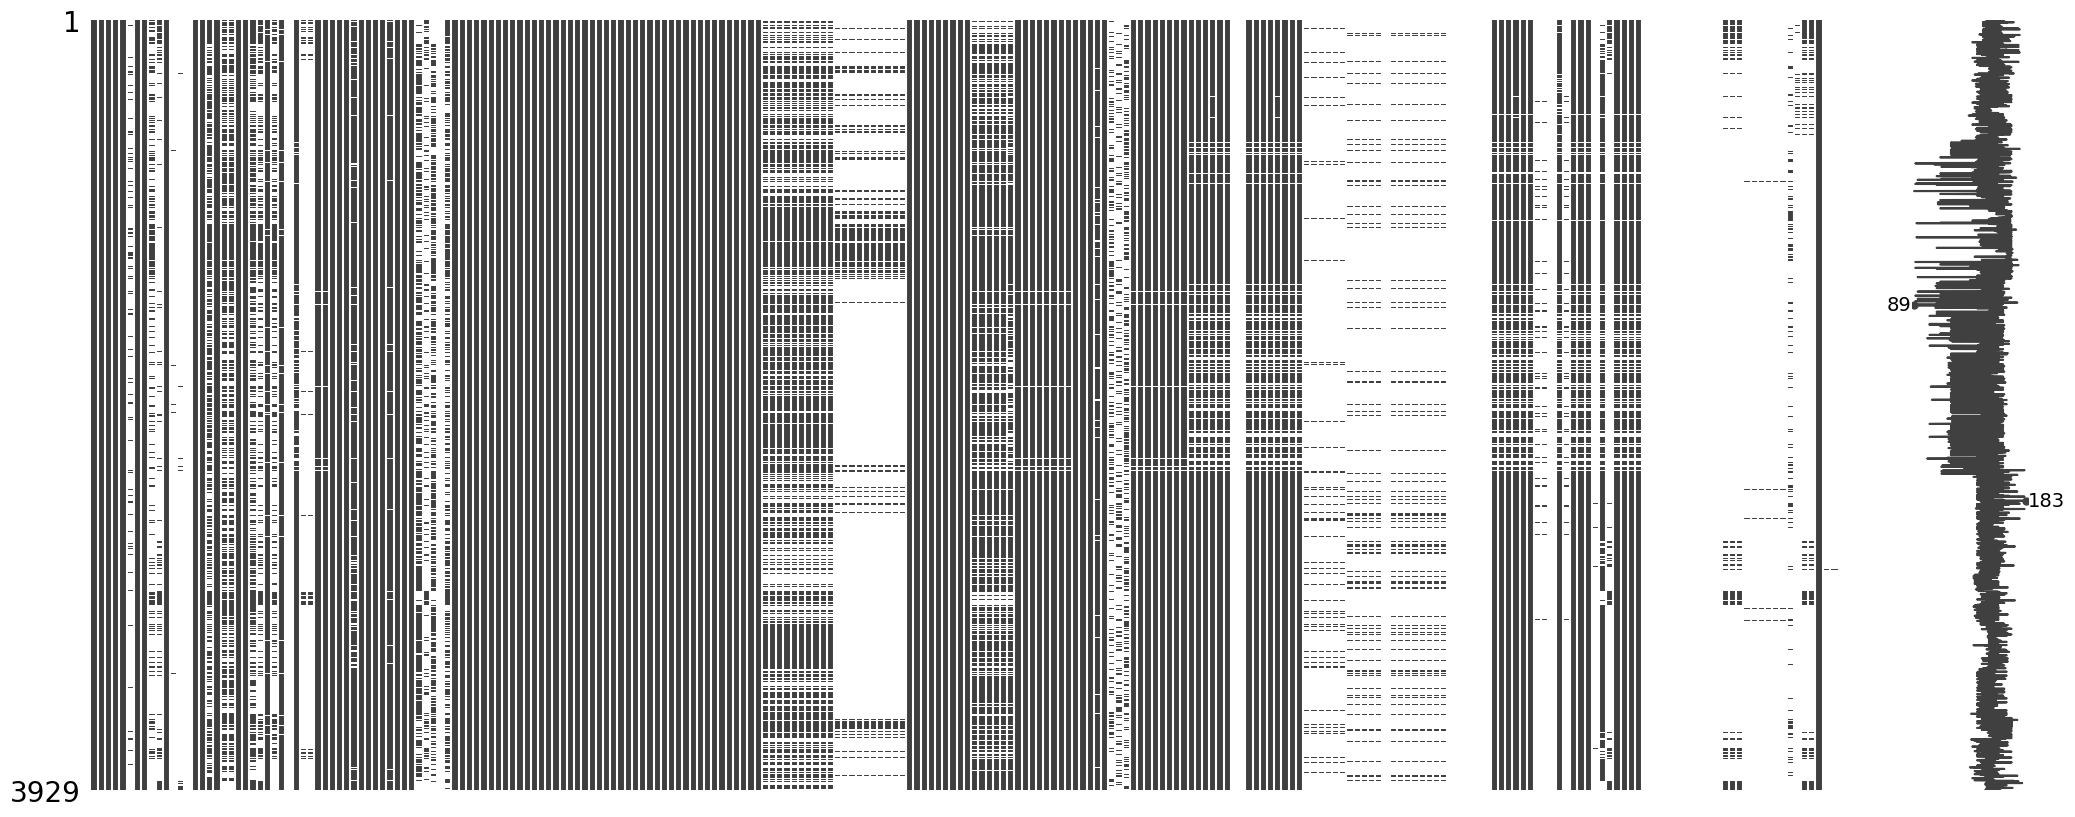

In [9]:
  
# Visualisation des valeurs manquantes en matrice
msno.matrix(sample_dpe_abbbeville) 

In [10]:
print(sample_dpe_abbbeville.dtypes)


N°DPE                                                   object
Date_réception_DPE                                      object
Date_établissement_DPE                                  object
Date_visite_diagnostiqueur                              object
Modèle_DPE                                              object
                                                        ...   
Système_production_électricité_origine_renouvelable     object
Présence_production_PV_(0/1)                           float64
Production_électricité_PV_(kWhep/an)                   float64
Surface_totale_capteurs_photovoltaïque                 float64
Nombre_module                                          float64
Length: 242, dtype: object


In [11]:
                     
# Vérification de la structure
display(sample_dpe_abbbeville.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Columns: 242 entries, N°DPE to Nombre_module
dtypes: float64(155), int64(5), object(82)
memory usage: 7.3+ MB


None

In [12]:
sample_dpe_abbbeville.isnull().sum()

N°DPE                                                     0
Date_réception_DPE                                        0
Date_établissement_DPE                                    0
Date_visite_diagnostiqueur                                0
Modèle_DPE                                                0
                                                       ... 
Système_production_électricité_origine_renouvelable    3445
Présence_production_PV_(0/1)                           3445
Production_électricité_PV_(kWhep/an)                      0
Surface_totale_capteurs_photovoltaïque                 3927
Nombre_module                                          3927
Length: 242, dtype: int64

In [13]:
sample_dpe_abbbeville.describe()

,Version_DPE,Appartement_non_visité_(0/1),N°_RPLS_logement,Année_construction,Hauteur_sous-plafond,Nombre_appartement,Nombre_niveau_immeuble,Nombre_niveau_logement,Surface_habitable_immeuble,Surface_habitable_logement,...,Surface_ventilée,Ventilation_postérieure_2012_(0/1),Conso_refroidissement_annuel,Conso_refroidissement_dépensier_annuel,Surface_climatisée,Electricité_PV_autoconsommée,Présence_production_PV_(0/1),Production_électricité_PV_(kWhep/an),Surface_totale_capteurs_photovoltaïque,Nombre_module
count,3929.000000,603.000000,0.0,2540.000000,3929.000000,2412.000000,1439.000000,3826.000000,1404.000000,3837.000000,...,411.000000,411.000000,14.000000,14.000000,14.000000,90.000000,484.000000,3929.000000,2.000000,2.000000
mean,2.142199,0.258706,NaN,1973.373228,2.580529,16.184494,3.487144,1.499739,1611.968162,68.363826,...,92.935280,0.343066,83.985714,414.542857,69.964286,0.822222,0.157025,3.938458,18.000000,15.000000
std,0.358084,0.438288,NaN,26.066387,0.317032,25.114081,1.059926,0.763634,1305.111048,32.468221,...,201.157935,0.475312,100.869808,637.047789,37.267941,0.384467,0.364201,178.601912,5.091169,4.242641
min,1.000000,0.000000,NaN,1780.000000,1.800000,1.000000,1.000000,1.000000,13.100000,8.000000,...,1.000000,0.000000,10.700000,35.500000,8.000000,0.000000,0.000000,0.000000,14.400000,12.000000
25%,2.200000,0.000000,NaN,1954.000000,2.500000,1.000000,3.000000,1.000000,731.300000,48.400000,...,48.400000,0.000000,23.875000,84.025000,42.550000,1.000000,0.000000,0.000000,16.200000,13.500000
50%,2.300000,0.000000,NaN,1970.000000,2.500000,1.000000,4.000000,1.000000,1359.900000,66.000000,...,65.100000,0.000000,40.200000,117.950000,64.300000,1.000000,0.000000,0.000000,18.000000,15.000000
75%,2.300000,1.000000,NaN,1996.000000,2.600000,24.000000,4.000000,2.000000,1988.000000,78.700000,...,78.000000,1.000000,114.775000,318.825000,94.575000,1.000000,0.000000,0.000000,19.800000,16.500000
max,2.400000,1.000000,NaN,2021.000000,8.100000,113.000000,8.000000,8.000000,5244.500000,400.000000,...,2675.000000,1.000000,373.100000,2227.900000,145.000000,1.000000,1.000000,9415.400000,21.600000,18.000000


In [14]:
# Suppression des valeurs aberrantes
sample_dpe_abbbeville = sample_dpe_abbbeville[(sample_dpe_abbbeville["Surface_habitable_logement"] >= 10) & (sample_dpe_abbbeville["Surface_habitable_logement"] <= 500)]
sample_dpe_abbbeville = sample_dpe_abbbeville[sample_dpe_abbbeville["Conso_5_usages_é_finale"] < 100_000]  # Filtrage des consommations extrêmes
sample_dpe_abbbeville = sample_dpe_abbbeville[sample_dpe_abbbeville["Conso_5_usages/m²_é_finale"] < 500]  # Limite selon les normes énergétiques
sample_dpe_abbbeville = sample_dpe_abbbeville[sample_dpe_abbbeville["Conso_chauffage_é_finale"] < 100_000]  # Énergie chauffage
sample_dpe_abbbeville = sample_dpe_abbbeville[sample_dpe_abbbeville["Conso_ECS_é_finale"] < 20_000]  # Eau chaude sanitaire


Etude des adresses

In [15]:

# Je vérifie si la colonne Adresse_(BAN) peut etre utilisée pour la normalisation
display(sample_dpe_abbbeville[["Adresse_(BAN)", "Etiquette_DPE"]])

,Adresse_(BAN),Etiquette_DPE
0,Abbeville,C
1,36 Rue du Prayel 80100 Abbeville,G
2,14 Quai de la Pointe 80100 Abbeville,E
3,Rue du Château d'Eau 80100 Abbeville,E
4,Abbeville,C
...,...,...
3924,27 Rue Ledien 80100 Abbeville,D
3925,89 Rue de Menchecourt 80100 Abbeville,D
3926,54 Route d’Amiens 80100 Abbeville,D
3927,1 Bourg du Vimeu 80100 Abbeville,E


In [16]:

# Fonction pour vérifier si une adresse est complète
def is_complete(address):
    address = address.strip()  # Supprime les espaces inutiles
    
    # Regex pour détecter un numéro au début + une rue (lettres) et un code postal/ville à la fin
    pattern = r"^\d+\s+\D+\s+\d{5}\s+\D+$"
    
    return bool(re.match(pattern, address))

# Vérification avec la colonne Adresse_(BAN)
#df_filtre  = sample_dpe_abbbeville[sample_dpe_abbbeville["Adresse_(BAN)"].apply(is_complete)]
print(f"🔹 Avant filtrage : {sample_dpe_abbbeville.shape}")

# Application de la fonction pour virer les adresses incomplètes
sample_dpe_abbbeville = sample_dpe_abbbeville.copy()  #  Ajout pour éviter l'avertissement
sample_dpe_abbbeville = sample_dpe_abbbeville[sample_dpe_abbbeville["Adresse_(BAN)"].apply(is_complete)]

# Affichage avant/après filtrage
#print(f"🔹 Avant filtrage : {sample_dpe_abbbeville.shape}")
print(f"🔹 Après filtrage : {sample_dpe_abbbeville.shape}")
#print(f"🔹 Après filtrage : {df_filtre.shape}")

🔹 Avant filtrage : (3812, 242)
🔹 Après filtrage : (3449, 242)


In [17]:
sample_dpe_abbbeville["Adresse_(BAN)"]

1                       36 Rue du Prayel 80100 Abbeville
2                   14 Quai de la Pointe 80100 Abbeville
5                    25 Rue des Drapiers 80100 Abbeville
6                   4 Passage aux Herbes 80100 Abbeville
8                         18 Rue Ringois 80100 Abbeville
                              ...                       
3924                       27 Rue Ledien 80100 Abbeville
3925               89 Rue de Menchecourt 80100 Abbeville
3926                   54 Route d’Amiens 80100 Abbeville
3927                    1 Bourg du Vimeu 80100 Abbeville
3928    12 Chemin de sur-Somme à Laviers 80100 Abbeville
Name: Adresse_(BAN), Length: 3449, dtype: object

Recherche des adresses uniques

In [18]:
sample_dpe_abbbeville['Adresse_(BAN)'].unique()

array(['36 Rue du Prayel 80100 Abbeville',
       '14 Quai de la Pointe 80100 Abbeville',
       '25 Rue des Drapiers 80100 Abbeville', ...,
       '9 Voie de l’Agriculture 80100 Abbeville',
       '89 Rue de Menchecourt 80100 Abbeville',
       '54 Route d’Amiens 80100 Abbeville'], dtype=object)

In [19]:
sample_dpe_abbbeville['Adresse_(BAN)'].nunique()

1539

In [20]:

adresses_uniques = sample_dpe_abbbeville['Adresse_(BAN)'].value_counts()
adresses_uniques.to_csv("adresses_uniques.csv")

In [21]:
display(adresses_uniques)

Adresse_(BAN)
2 Rue de la Petite Cascade 80100 Abbeville        87
14 Quai de la Pointe 80100 Abbeville              56
1 Place Chantal Leblanc 80100 Abbeville           52
44 Rue des Pommiers 80100 Abbeville               48
5 Rue des Acacias 80100 Abbeville                 48
                                                  ..
49 Rue du Chaufour 80100 Abbeville                 1
30 Rue du Haut Mesnil 80100 Abbeville              1
2 Rue du Chevalier de la Barre 80100 Abbeville     1
22 Petite Rue Saint -Jacques 80100 Abbeville       1
120 Route de Rouen 80100 Abbeville                 1
Name: count, Length: 1539, dtype: int64

Il y a 1539 adresses uniques dans la colonne Adresse_(BAN) de l'échantillon des données DPE d'Abbeville.

Fonction de normalisation des adresses avec l'API de la BAN

In [22]:

def normaliser_adresse(adresse):
    """
    Prend une adresse en entrée et la normalise en utilisant l'API BAN.
    """
    url = "https://api-adresse.data.gouv.fr/search/"
    params = {"q": adresse, "limit": 1}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Vérifie les erreurs HTTP
        data = response.json()
        
        if "features" in data and len(data["features"]) > 0:
            best_match = data["features"][0]["properties"]
            return best_match.get("label", adresse)  # Retourne l'adresse normalisée ou l'originale si absente
        else:
            print(f"⚠️ Aucune correspondance trouvée pour : {adresse}")
            return adresse  # Retourne l'adresse d'origine pour éviter None

    except requests.exceptions.RequestException as e:
        print(f"❌ Erreur API BAN pour {adresse} : {e}")
        return adresse  # Retourne l'adresse d'origine en cas d'erreur API

In [23]:
# Appliquer la normalisation API BAN sur l'échantillon
sample_dpe_abbbeville = sample_dpe_abbbeville.copy()
sample_dpe_abbbeville["Adresse_Normalisée"] = sample_dpe_abbbeville["Adresse_(BAN)"].apply(normaliser_adresse)

In [24]:
# Vérification des résultats
print("🔹 Exemples d'adresses DPE avant et après normalisation :")
display(sample_dpe_abbbeville[["Adresse_(BAN)", "Adresse_Normalisée"]].head(10))

🔹 Exemples d'adresses DPE avant et après normalisation :


,Adresse_(BAN),Adresse_Normalisée
1,36 Rue du Prayel 80100 Abbeville,36 Rue du Prayel 80100 Abbeville
2,14 Quai de la Pointe 80100 Abbeville,14 Quai de la Pointe 80100 Abbeville
5,25 Rue des Drapiers 80100 Abbeville,25 Rue des Drapiers 80100 Abbeville
6,4 Passage aux Herbes 80100 Abbeville,4 Passage aux Herbes 80100 Abbeville
8,18 Rue Ringois 80100 Abbeville,18 Rue Ringois 80100 Abbeville
9,14 Quai de la Pointe 80100 Abbeville,14 Quai de la Pointe 80100 Abbeville
10,44 Rue Ledien 80100 Abbeville,44 Rue Ledien 80100 Abbeville
11,14 Avenue de la Gare 80100 Abbeville,14 Avenue de la Gare 80100 Abbeville
12,25 Rue des Drapiers 80100 Abbeville,25 Rue des Drapiers 80100 Abbeville
13,40 Place de la Liberation 80100 Abbeville,40 Place de la Liberation 80100 Abbeville


In [25]:
# On compte les adresses normalisées
nombre_normalisees = (sample_dpe_abbbeville["Adresse_Normalisée"] != sample_dpe_abbbeville["Adresse_(BAN)"]).sum()

print(f"\n✅ Nombre d'adresses normalisées avec succès : {nombre_normalisees}/{len(adresses_uniques)}")



✅ Nombre d'adresses normalisées avec succès : 49/1539


La grande majorité des adresses étaient donc déjà normalisées.

In [26]:
adresses_norm_dpe = sample_dpe_abbbeville['Adresse_Normalisée'].value_counts()
display(adresses_norm_dpe)

Adresse_Normalisée
2 Rue de la Petite Cascade 80100 Abbeville    87
14 Quai de la Pointe 80100 Abbeville          56
1 Place Chantal Leblanc 80100 Abbeville       52
44 Rue des Pommiers 80100 Abbeville           48
5 Rue des Acacias 80100 Abbeville             48
                                              ..
9 Place Saint-jacques 80100 Abbeville          1
46 Faubourg des Planches 80100 Abbeville       1
14 Avenue de la Gare 80100 Abbeville           1
18 Rue Ringois 80100 Abbeville                 1
4 Passage aux Herbes 80100 Abbeville           1
Name: count, Length: 1530, dtype: int64

Création d'une nouvelle colonne fusionnant les données sur l'adresse afin d'effectuer une nouvelle normalisation

In [27]:
#colonnes_a_visualiser = ["Nom__commune_(BAN)", "Adresse_brute"]
#sample_dpe_abbbeville[colonnes_a_visualiser].head()

In [28]:
# Normalisation basique des noms de commune et adresses pour mettre au meme format 
#sample_dpe_abbbeville["Commune_Norm"] = sample_dpe_abbbeville["Nom__commune_(BAN)"].str.upper().str.strip()
#sample_dpe_abbbeville["Adresse_Norm"] = sample_dpe_abbbeville["Adresse_brute"].str.upper().str.strip()

In [29]:
# Création d'une nouvelle colonne combinant l'adresse, le code commune et la ville
#sample_dpe_abbbeville = sample_dpe_abbbeville.copy()  #  Ajout pour éviter l'avertissement

#sample_dpe_abbbeville.loc[:,"Adresse_Dpe"] = sample_dpe_abbbeville["Adresse_Norm"] + " " + sample_dpe_abbbeville["Code_INSEE_(BAN)"].astype(str)+ " " + sample_dpe_abbbeville["Commune_Norm"]

#print(sample_dpe_abbbeville[["Adresse_Norm", "Code_INSEE_(BAN)", "Commune_Norm", "Adresse_Dpe"]].head(10))

In [30]:
## Fonction pour vérifier si une adresse est complète
#def is_complete(address):
#    address = address.strip()  # Supprime les espaces inutiles
#    
#    # Regex pour détecter un numéro au début + une rue (lettres) et un code postal/ville à la fin
#    pattern = r"^\d+\s+\D+\s+\d{5}\s+\D+$"
#    
#    return bool(re.match(pattern, address))
#
## je vérifie s'il y avait des adresses incomplètes
#print(f"🔹 Avant filtrage : {sample_dpe_abbbeville.shape}")
#
## Application de la fonction pour virer les adresses incomplètes
#sample_dpe_abbbeville = sample_dpe_abbbeville.copy()  #  Ajout pour éviter l'avertissement
#sample_dpe_abbbeville = sample_dpe_abbbeville[sample_dpe_abbbeville["Adresse_Dpe"].apply(is_complete)]
#
## Affichage avant/après filtrage
##print(f"🔹 Avant filtrage : {sample_dpe_abbbeville.shape}")
#print(f"🔹 Après filtrage : {sample_dpe_abbbeville.shape}")
#print(f"🔹 Après filtrage : {df_filtre.shape}")

In [31]:
# Application de la normalisation API BAN sur cette colonne
#sample_dpe_abbbeville = sample_dpe_abbbeville.copy()
#sample_dpe_abbbeville["Adresse_Normalisée_Dpe"] = sample_dpe_abbbeville["Adresse_Dpe"].apply(normaliser_adresse)

In [32]:
# Vérification des résultats
#print("🔹 Exemples d'adresses DPE avant et après normalisation :")
#display(sample_dpe_abbbeville[["Adresse_Dpe", "Adresse_Normalisée_Dpe"]].head(1000))

In [33]:
#sample_dpe_abbbeville['Adresse_Dpe'].nunique()

Il y a 1731 adresses uniques dans la colonne Adresse_Dpe de l'échantillon des données DPE d'Abbeville.

In [34]:
#sample_dpe_abbbeville['Adresse_(BAN)'].nunique()

In [35]:
#sample_dpe_abbbeville['Adresse_Normalisée_Dpe'].nunique()

In [36]:
#adresses_uniques_n_dpe = sample_dpe_abbbeville['Adresse_Dpe'].value_counts()
#adresses_uniques_n_dpe.to_csv("adresses_uniques_n_dpe.csv")

In [37]:
#display(adresses_uniques_n_dpe)

In [38]:
# Compter les adresses effectivement normalisées
#nombre_normalisee = (sample_dpe_abbbeville["Adresse_Normalisée_Dpe"] != sample_dpe_abbbeville["Adresse_Dpe"]).sum()
#
#print(f"\n✅ Nombre d'adresses normalisées avec succès : {nombre_normalisee}/{len(adresses_uniques_n_dpe)}")

Données de consommation électrique

In [39]:
conso_enedis = pd.read_csv("consommation-annuelle-residentielle-par-adresse.csv", sep=";")
conso_enedis.head()

C:\Users\Admin.local\AppData\Local\Temp\ipykernel_3240\2725509276.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  conso_enedis = pd.read_csv("consommation-annuelle-residentielle-par-adresse.csv", sep=";")


,Année,Code IRIS,Nom IRIS,Numéro de voie,Indice de répétition,Type de voie,Libellé de voie,Code Commune,Nom Commune,Segment de client,Nombre de logements,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Adresse,Code EPCI,Code Département,Code Région,Tri des adresses
0,2019,800010401,Faubourg de la Bouvaque,11.0,NaN,ROUTE,DE DOULLENS,80001,Abbeville,RESIDENTIEL,25,164.574,6.583,3.428,11 ROUTE DE DOULLENS,200070993.0,80.0,32.0,9
1,2019,800010102,Centre Ville-Saint-Vulfran,9.0,NaN,PLACE,DE L AMIRAL COURBET,80001,Abbeville,RESIDENTIEL,20,28.753,1.438,3.428,9 PLACE DE L AMIRAL COURBET,200070993.0,80.0,32.0,13
2,2019,800010502,Delique-Saint Gilles,15.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,34.632,3.463,3.428,15 RUE DE NORMANDIE,200070993.0,80.0,32.0,25
3,2019,800010502,Delique-Saint Gilles,13.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,41.706,4.171,3.428,13 RUE DE NORMANDIE,200070993.0,80.0,32.0,27
4,2019,800010502,Delique-Saint Gilles,7.0,NaN,RUE,DE PICARDIE,80001,Abbeville,RESIDENTIEL,10,34.086,3.409,3.428,7 RUE DE PICARDIE,200070993.0,80.0,32.0,38


In [40]:
conso_enedis.shape

(2395046, 19)

In [41]:
conso_enedis.columns

Index(['Année', 'Code IRIS', 'Nom IRIS', 'Numéro de voie',
       'Indice de répétition', 'Type de voie', 'Libellé de voie',
       'Code Commune', 'Nom Commune', 'Segment de client',
       'Nombre de logements',
       'Consommation annuelle totale de l'adresse (MWh)',
       'Consommation annuelle moyenne par logement de l'adresse (MWh)',
       'Consommation annuelle moyenne de la commune (MWh)', 'Adresse',
       'Code EPCI', 'Code Département', 'Code Région', 'Tri des adresses'],
      dtype='object')

In [42]:
#je prends les colonnes utiles pour ne pas saturer la mémoire

#colonnes_utiles_enedis = ["Année","Adresse", "Code Commune", "Nom Commune","Consommation annuelle totale de l'adresse (MWh)", "Consommation annuelle moyenne par logement de l'adresse (MWh)", "Nombre de logements"]
conso_enedis = pd.read_csv(r"C:\Users\Admin.local\Desktop\Cours\Open Data University\consommation-annuelle-residentielle-par-adresse.csv", 
                           sep=";", low_memory=False) #usecols=colonnes_utiles_enedis

display(conso_enedis.head())
display(conso_enedis.info())

,Année,Code IRIS,Nom IRIS,Numéro de voie,Indice de répétition,Type de voie,Libellé de voie,Code Commune,Nom Commune,Segment de client,Nombre de logements,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Adresse,Code EPCI,Code Département,Code Région,Tri des adresses
0,2019,800010401,Faubourg de la Bouvaque,11.0,NaN,ROUTE,DE DOULLENS,80001,Abbeville,RESIDENTIEL,25,164.574,6.583,3.428,11 ROUTE DE DOULLENS,200070993.0,80.0,32.0,9
1,2019,800010102,Centre Ville-Saint-Vulfran,9.0,NaN,PLACE,DE L AMIRAL COURBET,80001,Abbeville,RESIDENTIEL,20,28.753,1.438,3.428,9 PLACE DE L AMIRAL COURBET,200070993.0,80.0,32.0,13
2,2019,800010502,Delique-Saint Gilles,15.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,34.632,3.463,3.428,15 RUE DE NORMANDIE,200070993.0,80.0,32.0,25
3,2019,800010502,Delique-Saint Gilles,13.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,41.706,4.171,3.428,13 RUE DE NORMANDIE,200070993.0,80.0,32.0,27
4,2019,800010502,Delique-Saint Gilles,7.0,NaN,RUE,DE PICARDIE,80001,Abbeville,RESIDENTIEL,10,34.086,3.409,3.428,7 RUE DE PICARDIE,200070993.0,80.0,32.0,38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395046 entries, 0 to 2395045
Data columns (total 19 columns):
 #   Column                                                         Dtype  
---  ------                                                         -----  
 0   Année                                                          int64  
 1   Code IRIS                                                      object 
 2   Nom IRIS                                                       object 
 3   Numéro de voie                                                 float64
 4   Indice de répétition                                           object 
 5   Type de voie                                                   object 
 6   Libellé de voie                                                object 
 7   Code Commune                                                   int64  
 8   Nom Commune                                                    object 
 9   Segment de client                             

None

Je prend un échantillon, je filtre sur le code commune correspondant à Abbeville

In [43]:
sample_enedis = conso_enedis.loc[conso_enedis["Code Commune"] == 80001]
sample_enedis.head()

,Année,Code IRIS,Nom IRIS,Numéro de voie,Indice de répétition,Type de voie,Libellé de voie,Code Commune,Nom Commune,Segment de client,Nombre de logements,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Adresse,Code EPCI,Code Département,Code Région,Tri des adresses
0,2019,800010401,Faubourg de la Bouvaque,11.0,NaN,ROUTE,DE DOULLENS,80001,Abbeville,RESIDENTIEL,25,164.574,6.583,3.428,11 ROUTE DE DOULLENS,200070993.0,80.0,32.0,9
1,2019,800010102,Centre Ville-Saint-Vulfran,9.0,NaN,PLACE,DE L AMIRAL COURBET,80001,Abbeville,RESIDENTIEL,20,28.753,1.438,3.428,9 PLACE DE L AMIRAL COURBET,200070993.0,80.0,32.0,13
2,2019,800010502,Delique-Saint Gilles,15.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,34.632,3.463,3.428,15 RUE DE NORMANDIE,200070993.0,80.0,32.0,25
3,2019,800010502,Delique-Saint Gilles,13.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,41.706,4.171,3.428,13 RUE DE NORMANDIE,200070993.0,80.0,32.0,27
4,2019,800010502,Delique-Saint Gilles,7.0,NaN,RUE,DE PICARDIE,80001,Abbeville,RESIDENTIEL,10,34.086,3.409,3.428,7 RUE DE PICARDIE,200070993.0,80.0,32.0,38


In [44]:
sample_enedis.shape

(782, 19)

<Axes: >

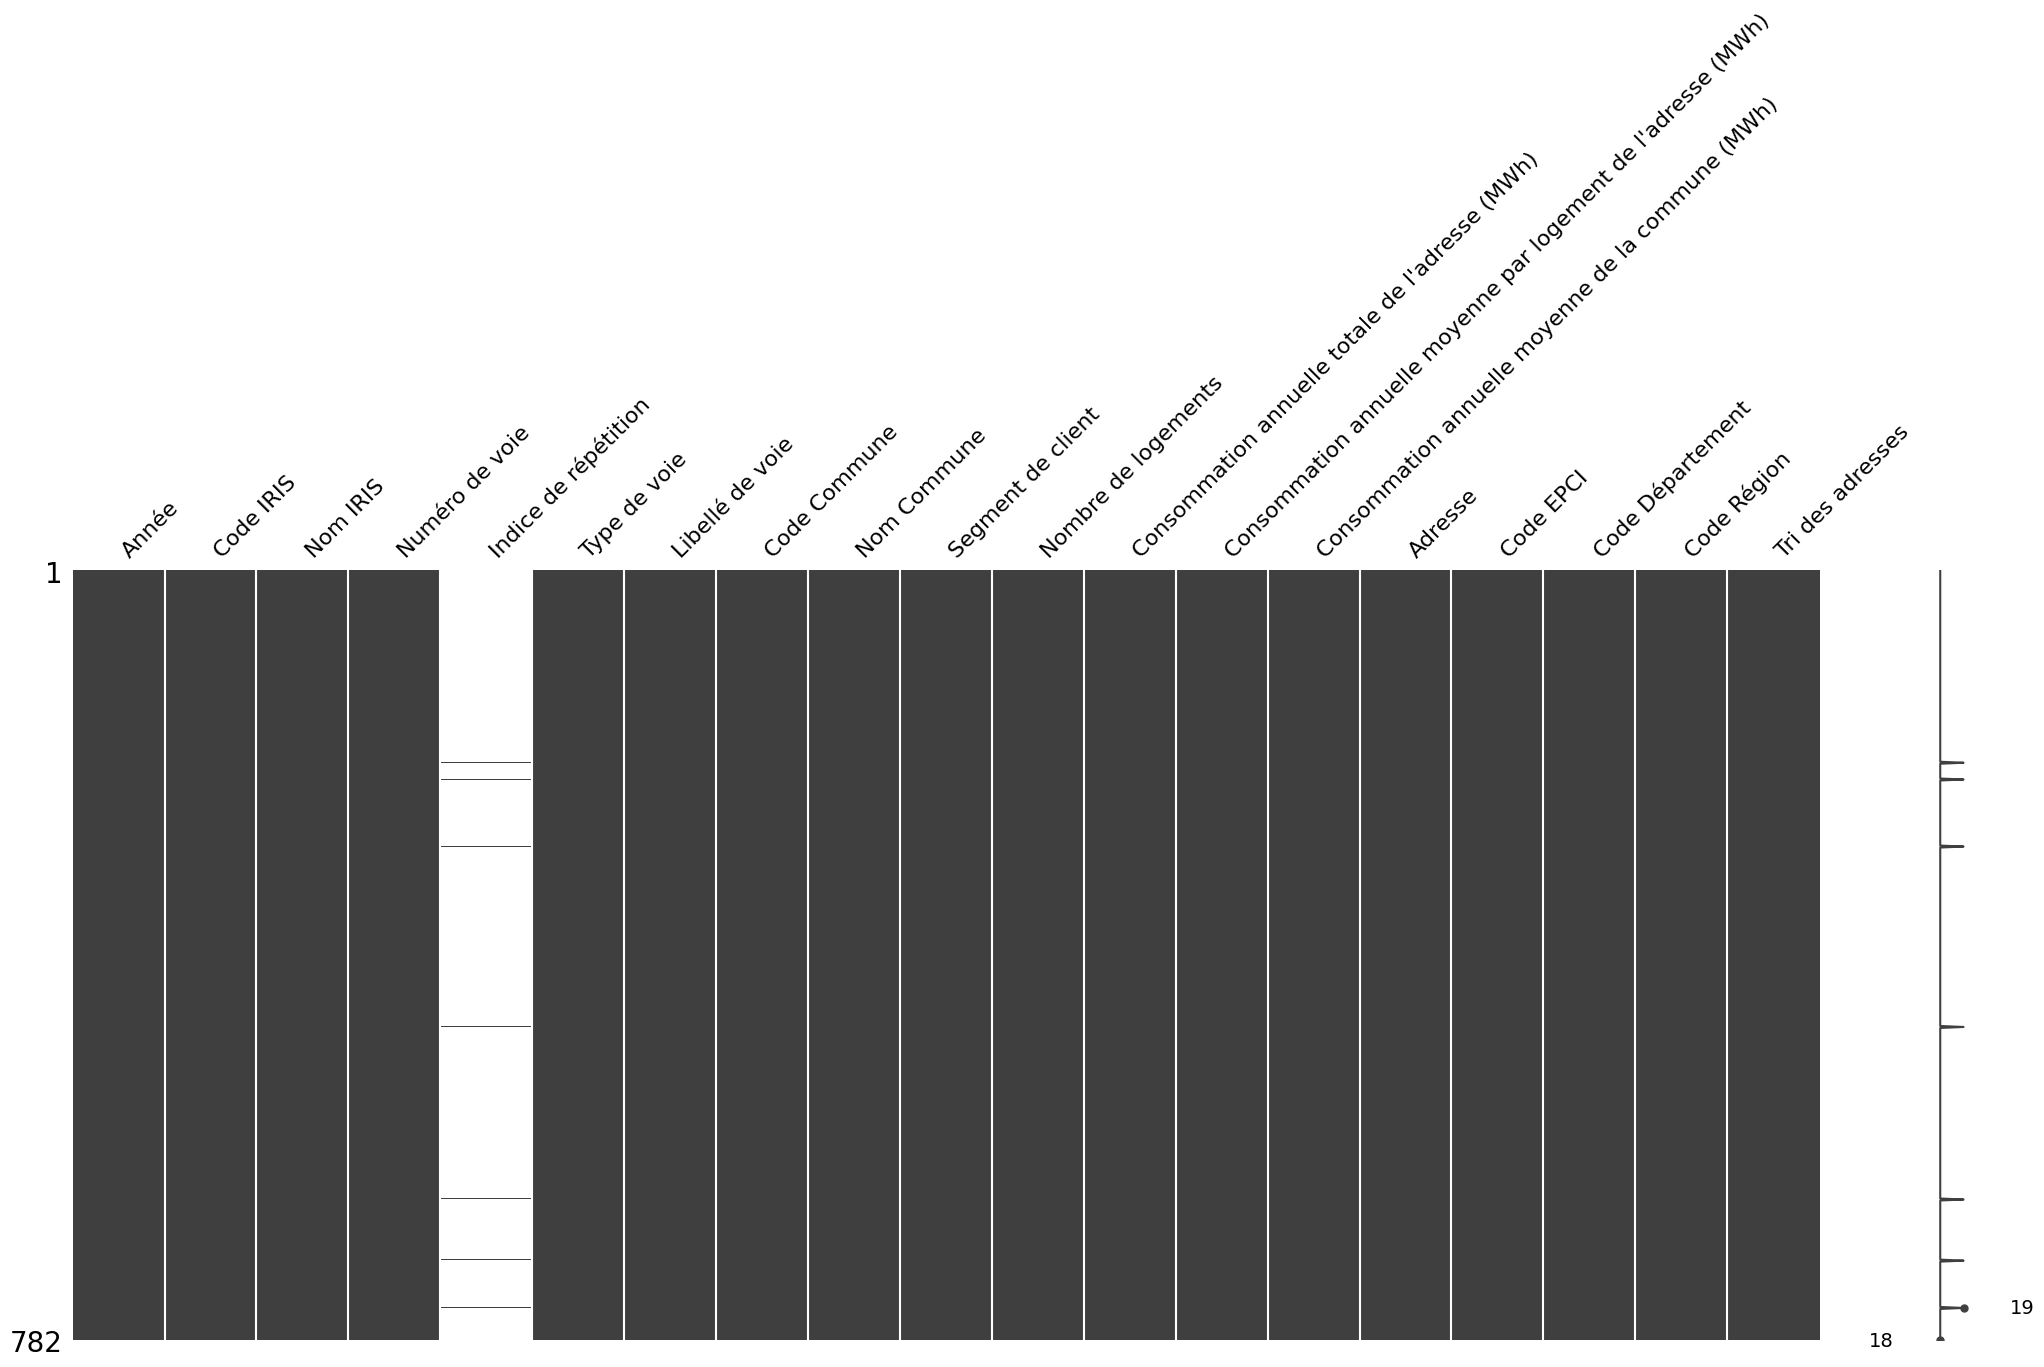

In [45]:
  
# Visualisation des valeurs manquantes en matrice
msno.matrix(sample_enedis) 

In [46]:
# Normalisation basique des noms de commune enedis pour mettre au m^^eme format que l'adresse

sample_enedis = sample_enedis.copy()  #  Ajout pour éviter l'avertissement
sample_enedis.loc[:, "Commune_Norm"] = sample_enedis["Nom Commune"].str.upper().str.strip()

In [47]:
# Création d'une nouvelle colonne combinant l'adresse, le code commune et la ville

sample_enedis = sample_enedis.copy()  #  Ajout pour éviter l'avertissement
sample_enedis.loc[:, "Adresse_Complète"] = sample_enedis["Adresse"] + " " + sample_enedis["Code Commune"].astype(str) + " " + sample_enedis["Commune_Norm"]

print(sample_enedis[["Adresse", "Code Commune", "Commune_Norm", "Adresse_Complète"]].head(10))



                           Adresse  Code Commune Commune_Norm  \
0             11 ROUTE DE DOULLENS         80001    ABBEVILLE   
1      9 PLACE DE L AMIRAL COURBET         80001    ABBEVILLE   
2              15 RUE DE NORMANDIE         80001    ABBEVILLE   
3              13 RUE DE NORMANDIE         80001    ABBEVILLE   
4                7 RUE DE PICARDIE         80001    ABBEVILLE   
5              24 RUE DES CAPUCINS         80001    ABBEVILLE   
6              18 RUE DES PLATANES         80001    ABBEVILLE   
7   6 RUE DU 128E RGT D INFANTERIE         80001    ABBEVILLE   
8  23 RUE DU CHEVALIER DE LA BARRE         80001    ABBEVILLE   
9   3 RUE DU CHEVALIER DE LA BARRE         80001    ABBEVILLE   

                                  Adresse_Complète  
0             11 ROUTE DE DOULLENS 80001 ABBEVILLE  
1      9 PLACE DE L AMIRAL COURBET 80001 ABBEVILLE  
2              15 RUE DE NORMANDIE 80001 ABBEVILLE  
3              13 RUE DE NORMANDIE 80001 ABBEVILLE  
4                7 

In [48]:
display(sample_enedis)

,Année,Code IRIS,Nom IRIS,Numéro de voie,Indice de répétition,Type de voie,Libellé de voie,Code Commune,Nom Commune,Segment de client,...,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Adresse,Code EPCI,Code Département,Code Région,Tri des adresses,Commune_Norm,Adresse_Complète
0,2019,800010401,Faubourg de la Bouvaque,11.0,NaN,ROUTE,DE DOULLENS,80001,Abbeville,RESIDENTIEL,...,164.574,6.583,3.428,11 ROUTE DE DOULLENS,200070993.0,80.0,32.0,9,ABBEVILLE,11 ROUTE DE DOULLENS 80001 ABBEVILLE
1,2019,800010102,Centre Ville-Saint-Vulfran,9.0,NaN,PLACE,DE L AMIRAL COURBET,80001,Abbeville,RESIDENTIEL,...,28.753,1.438,3.428,9 PLACE DE L AMIRAL COURBET,200070993.0,80.0,32.0,13,ABBEVILLE,9 PLACE DE L AMIRAL COURBET 80001 ABBEVILLE
2,2019,800010502,Delique-Saint Gilles,15.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,...,34.632,3.463,3.428,15 RUE DE NORMANDIE,200070993.0,80.0,32.0,25,ABBEVILLE,15 RUE DE NORMANDIE 80001 ABBEVILLE
3,2019,800010502,Delique-Saint Gilles,13.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,...,41.706,4.171,3.428,13 RUE DE NORMANDIE,200070993.0,80.0,32.0,27,ABBEVILLE,13 RUE DE NORMANDIE 80001 ABBEVILLE
4,2019,800010502,Delique-Saint Gilles,7.0,NaN,RUE,DE PICARDIE,80001,Abbeville,RESIDENTIEL,...,34.086,3.409,3.428,7 RUE DE PICARDIE,200070993.0,80.0,32.0,38,ABBEVILLE,7 RUE DE PICARDIE 80001 ABBEVILLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373759,2020,800010301,Faubourg de Menchecourt,14.0,NaN,RUE,HENRI SELLIER,80001,Abbeville,RESIDENTIEL,...,47.945,1.498,3.440,14 RUE HENRI SELLIER,200070993.0,80.0,32.0,98,ABBEVILLE,14 RUE HENRI SELLIER 80001 ABBEVILLE
2373760,2020,800010201,La Gare-Rouvroy-La Portelette,20.0,NaN,RUE,JEAN JAURES,80001,Abbeville,RESIDENTIEL,...,23.850,1.325,3.440,20 RUE JEAN JAURES,200070993.0,80.0,32.0,107,ABBEVILLE,20 RUE JEAN JAURES 80001 ABBEVILLE
2373761,2020,800010201,La Gare-Rouvroy-La Portelette,40.0,NaN,RUE,LOUANDRE,80001,Abbeville,RESIDENTIEL,...,56.837,1.624,3.440,40 RUE LOUANDRE,200070993.0,80.0,32.0,118,ABBEVILLE,40 RUE LOUANDRE 80001 ABBEVILLE
2373762,2020,800010201,La Gare-Rouvroy-La Portelette,24.0,NaN,RUE,LOUANDRE,80001,Abbeville,RESIDENTIEL,...,34.925,1.663,3.440,24 RUE LOUANDRE,200070993.0,80.0,32.0,119,ABBEVILLE,24 RUE LOUANDRE 80001 ABBEVILLE


In [49]:

# normalisation avec API BAN sur l'échantillon
sample_enedis = sample_enedis.copy()  #  Ajout pour éviter l'avertissement
sample_enedis.loc[:, "Adresse_Normalisée"] = sample_enedis["Adresse_Complète"].apply(normaliser_adresse)

# Vérifier les résultats
print("🔹 Exemples d'adresses Enedis avant et après normalisation :")
print(sample_enedis[["Adresse_Complète", "Adresse_Normalisée"]].head(10))

🔹 Exemples d'adresses Enedis avant et après normalisation :
                                  Adresse_Complète  \
0             11 ROUTE DE DOULLENS 80001 ABBEVILLE   
1      9 PLACE DE L AMIRAL COURBET 80001 ABBEVILLE   
2              15 RUE DE NORMANDIE 80001 ABBEVILLE   
3              13 RUE DE NORMANDIE 80001 ABBEVILLE   
4                7 RUE DE PICARDIE 80001 ABBEVILLE   
5              24 RUE DES CAPUCINS 80001 ABBEVILLE   
6              18 RUE DES PLATANES 80001 ABBEVILLE   
7   6 RUE DU 128E RGT D INFANTERIE 80001 ABBEVILLE   
8  23 RUE DU CHEVALIER DE LA BARRE 80001 ABBEVILLE   
9   3 RUE DU CHEVALIER DE LA BARRE 80001 ABBEVILLE   

                                Adresse_Normalisée  
0             11 Route de Doullens 80100 Abbeville  
1      9 Place de l’Amiral Courbet 80100 Abbeville  
2              15 Rue de Normandie 80100 Abbeville  
3              13 Rue de Normandie 80100 Abbeville  
4                7 Rue de Picardie 80100 Abbeville  
5              24 Rue des C

In [50]:
adresses_uniques_enedis = sample_enedis['Adresse_Normalisée'].value_counts()
adresses_uniques_enedis.to_csv("adresses_uniques_enedis.csv")

In [51]:
adresses_uniques_enedis

Adresse_Normalisée
11 Route de Doullens 80100 Abbeville           6
9 Place de l’Amiral Courbet 80100 Abbeville    6
15 Rue de Normandie 80100 Abbeville            6
18 Rue des Platanes 80100 Abbeville            6
24 Rue des Capucins 80100 Abbeville            6
                                              ..
13a Rue Millevoye 80100 Abbeville              1
40 Rue du Maréchal Foch 80100 Abbeville        1
16 Rue Leon Blum 80100 Abbeville               1
17 Rue aux Pareurs 80100 Abbeville             1
26 Rue de Picardie 80100 Abbeville             1
Name: count, Length: 147, dtype: int64

Il y a 148 adresses uniques dans les adresses normalisées des données Enedis d'Abbeville.

In [52]:
# Compter les adresses effectivement normalisées
nombre_normalisees = (sample_enedis["Adresse_Normalisée"] != sample_enedis["Adresse_Complète"]).sum()

print(f"\n✅ Nombre d'adresses normalisées avec succès : {nombre_normalisees}/{len(sample_enedis)}")



✅ Nombre d'adresses normalisées avec succès : 782/782


In [53]:
display(sample_enedis.head(5))

,Année,Code IRIS,Nom IRIS,Numéro de voie,Indice de répétition,Type de voie,Libellé de voie,Code Commune,Nom Commune,Segment de client,...,Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Adresse,Code EPCI,Code Département,Code Région,Tri des adresses,Commune_Norm,Adresse_Complète,Adresse_Normalisée
0,2019,800010401,Faubourg de la Bouvaque,11.0,NaN,ROUTE,DE DOULLENS,80001,Abbeville,RESIDENTIEL,...,6.583,3.428,11 ROUTE DE DOULLENS,200070993.0,80.0,32.0,9,ABBEVILLE,11 ROUTE DE DOULLENS 80001 ABBEVILLE,11 Route de Doullens 80100 Abbeville
1,2019,800010102,Centre Ville-Saint-Vulfran,9.0,NaN,PLACE,DE L AMIRAL COURBET,80001,Abbeville,RESIDENTIEL,...,1.438,3.428,9 PLACE DE L AMIRAL COURBET,200070993.0,80.0,32.0,13,ABBEVILLE,9 PLACE DE L AMIRAL COURBET 80001 ABBEVILLE,9 Place de l’Amiral Courbet 80100 Abbeville
2,2019,800010502,Delique-Saint Gilles,15.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,...,3.463,3.428,15 RUE DE NORMANDIE,200070993.0,80.0,32.0,25,ABBEVILLE,15 RUE DE NORMANDIE 80001 ABBEVILLE,15 Rue de Normandie 80100 Abbeville
3,2019,800010502,Delique-Saint Gilles,13.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,...,4.171,3.428,13 RUE DE NORMANDIE,200070993.0,80.0,32.0,27,ABBEVILLE,13 RUE DE NORMANDIE 80001 ABBEVILLE,13 Rue de Normandie 80100 Abbeville
4,2019,800010502,Delique-Saint Gilles,7.0,NaN,RUE,DE PICARDIE,80001,Abbeville,RESIDENTIEL,...,3.409,3.428,7 RUE DE PICARDIE,200070993.0,80.0,32.0,38,ABBEVILLE,7 RUE DE PICARDIE 80001 ABBEVILLE,7 Rue de Picardie 80100 Abbeville


In [54]:
sample_enedis = sample_enedis.copy()  #  Ajout pour éviter l'avertissement
sample_enedis = sample_enedis.drop(columns=['Adresse', 'Commune_Norm', 'Adresse_Complète'])

In [55]:
display(sample_enedis)

,Année,Code IRIS,Nom IRIS,Numéro de voie,Indice de répétition,Type de voie,Libellé de voie,Code Commune,Nom Commune,Segment de client,Nombre de logements,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Code EPCI,Code Département,Code Région,Tri des adresses,Adresse_Normalisée
0,2019,800010401,Faubourg de la Bouvaque,11.0,NaN,ROUTE,DE DOULLENS,80001,Abbeville,RESIDENTIEL,25,164.574,6.583,3.428,200070993.0,80.0,32.0,9,11 Route de Doullens 80100 Abbeville
1,2019,800010102,Centre Ville-Saint-Vulfran,9.0,NaN,PLACE,DE L AMIRAL COURBET,80001,Abbeville,RESIDENTIEL,20,28.753,1.438,3.428,200070993.0,80.0,32.0,13,9 Place de l’Amiral Courbet 80100 Abbeville
2,2019,800010502,Delique-Saint Gilles,15.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,34.632,3.463,3.428,200070993.0,80.0,32.0,25,15 Rue de Normandie 80100 Abbeville
3,2019,800010502,Delique-Saint Gilles,13.0,NaN,RUE,DE NORMANDIE,80001,Abbeville,RESIDENTIEL,10,41.706,4.171,3.428,200070993.0,80.0,32.0,27,13 Rue de Normandie 80100 Abbeville
4,2019,800010502,Delique-Saint Gilles,7.0,NaN,RUE,DE PICARDIE,80001,Abbeville,RESIDENTIEL,10,34.086,3.409,3.428,200070993.0,80.0,32.0,38,7 Rue de Picardie 80100 Abbeville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373759,2020,800010301,Faubourg de Menchecourt,14.0,NaN,RUE,HENRI SELLIER,80001,Abbeville,RESIDENTIEL,32,47.945,1.498,3.440,200070993.0,80.0,32.0,98,14 Rue Henri Sellier 80100 Abbeville
2373760,2020,800010201,La Gare-Rouvroy-La Portelette,20.0,NaN,RUE,JEAN JAURES,80001,Abbeville,RESIDENTIEL,18,23.850,1.325,3.440,200070993.0,80.0,32.0,107,20 Rue Jean Jaurés 80100 Abbeville
2373761,2020,800010201,La Gare-Rouvroy-La Portelette,40.0,NaN,RUE,LOUANDRE,80001,Abbeville,RESIDENTIEL,35,56.837,1.624,3.440,200070993.0,80.0,32.0,118,40 Rue Louandre 80100 Abbeville
2373762,2020,800010201,La Gare-Rouvroy-La Portelette,24.0,NaN,RUE,LOUANDRE,80001,Abbeville,RESIDENTIEL,21,34.925,1.663,3.440,200070993.0,80.0,32.0,119,24 Rue Louandre 80100 Abbeville


In [56]:
sample_enedis.to_csv("enedis_abbeville_norm.csv", index=False)

Comparer les adresses normalisées

In [57]:
# Comparer les adresses normalisées
adresses_dpe_ban = set(sample_dpe_abbbeville["Adresse_Normalisée"].dropna().unique())  # Toutes les adresses DPE
adresses_enedis_ban = set(sample_enedis["Adresse_Normalisée"].dropna().unique())  # Adresse avec le code postale 80001

# Trouver les correspondances exactes
adresses_communes_ban = adresses_enedis_ban.intersection(adresses_dpe_ban)

# Affichage des résultats
print(f"🔹 Nombre d'adresses Enedis trouvées dans DPE : {len(adresses_communes_ban)} / {len(adresses_enedis_ban)}")


🔹 Nombre d'adresses Enedis trouvées dans DPE : 53 / 147


In [58]:
sample_dpe_abbbeville.shape, sample_enedis.shape

((3449, 243), (782, 19))

In [59]:
# Afficher la liste des adresses trouvées
print("📌 Liste des adresses Enedis trouvées dans DPE :")
for adresse in sorted(adresses_communes_ban):  # Trier pour plus de lisibilité
    print(adresse)

📌 Liste des adresses Enedis trouvées dans DPE :
1 Place du Marche Jacques Becq 80100 Abbeville
1 Rue du Scardon 80100 Abbeville
10 Rue de Gascogne 80100 Abbeville
104 Rue du Château d'Eau 80100 Abbeville
11 Route de Doullens 80100 Abbeville
11 Rue Boucher de Perthes 80100 Abbeville
11 Rue Leon Blum 80100 Abbeville
13 Rue Millevoye 80100 Abbeville
132 Boulevard de la République 80100 Abbeville
14 Quai de la Pointe 80100 Abbeville
17 Rue aux Pareurs 80100 Abbeville
2 Avenue Aristide Briand 80100 Abbeville
2 Avenue du Président René Coty 80100 Abbeville
2 Place du Saint- Sépulcre 80100 Abbeville
2 Rue de la Réunion 80100 Abbeville
2 Rue des Drapiers 80100 Abbeville
23 Rue du Chevalier de la Barre 80100 Abbeville
24 Chaussée du Bois 80100 Abbeville
24 Rue Lefébure de Cerisy 80100 Abbeville
24 Rue des Capucins 80100 Abbeville
25 Rue des Drapiers 80100 Abbeville
264 Chaussée d'Hocquet 80100 Abbeville
27 Rue Ledien 80100 Abbeville
29 Rue Saint Gilles 80100 Abbeville
3 Rue Leon Blum 80100 Abbe

Merge des deux dataframe

In [60]:

# Fusionner les DataFrames sur les adresses normalisées
df_merged = sample_dpe_abbbeville.merge(sample_enedis, 
                            left_on="Adresse_Normalisée", 
                            right_on="Adresse_Normalisée", 
                            how="inner")  # 'inner' garde uniquement les correspondances

# Afficher les résultats
print(f"🔹 Nombre d'adresses correspondantes : {df_merged.shape[0]} / {sample_dpe_abbbeville.shape[0]} dans DPE")
print(f"🔹 Nombre total d'adresses Enedis : {sample_enedis.shape[0]}")

# Affichage du DataFrame fusionné
print("\n🔹 Aperçu des adresses fusionnées :")
display(df_merged.head())  # Afficher les 5 premières lignes



🔹 Nombre d'adresses correspondantes : 2722 / 3449 dans DPE
🔹 Nombre total d'adresses Enedis : 782

🔹 Aperçu des adresses fusionnées :


,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Nom Commune,Segment de client,Nombre de logements,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Code EPCI,Code Département,Code Région,Tri des adresses
0,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,51,289.837,5.683,3.428,200070993.0,80.0,32.0,17
1,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,52,282.623,5.435,3.185,200070993.0,80.0,32.0,20
2,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,52,290.334,5.583,3.243,200070993.0,80.0,32.0,20
3,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,52,324.325,6.237,3.546,200070993.0,80.0,32.0,18
4,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,ABBEVILLE,RESIDENTIEL,51,310.482,6.088,3.522,200070993.0,80.0,32.0,399866


In [61]:
df_merged.shape

(2722, 261)

In [62]:
sample_dpe_abbbeville.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['N°DPE', 'Date_réception_DPE', 'Date_établissement_DPE',
       'Date_visite_diagnostiqueur', 'Modèle_DPE', 'N°_DPE_remplacé',
       'Date_fin_validité_DPE', 'Version_DPE', 'N°_DPE_immeuble_associé',
       'Appartement_non_visité_(0/1)',
       ...
       'Surface_climatisée', 'Type_énergie_climatisation', 'Catégorie_ENR',
       'Electricité_PV_autoconsommée',
       'Système_production_électricité_origine_renouvelable',
       'Présence_production_PV_(0/1)', 'Production_électricité_PV_(kWhep/an)',
       'Surface_totale_capteurs_photovoltaïque', 'Nombre_module',
       'Adresse_Normalisée'],
      dtype='object', length=243)>

In [63]:
sample_enedis.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Année', 'Code IRIS', 'Nom IRIS', 'Numéro de voie',
       'Indice de répétition', 'Type de voie', 'Libellé de voie',
       'Code Commune', 'Nom Commune', 'Segment de client',
       'Nombre de logements',
       'Consommation annuelle totale de l'adresse (MWh)',
       'Consommation annuelle moyenne par logement de l'adresse (MWh)',
       'Consommation annuelle moyenne de la commune (MWh)', 'Code EPCI',
       'Code Département', 'Code Région', 'Tri des adresses',
       'Adresse_Normalisée'],
      dtype='object')>

In [64]:
df_merged.columns.to_list()

['N°DPE',
 'Date_réception_DPE',
 'Date_établissement_DPE',
 'Date_visite_diagnostiqueur',
 'Modèle_DPE',
 'N°_DPE_remplacé',
 'Date_fin_validité_DPE',
 'Version_DPE',
 'N°_DPE_immeuble_associé',
 'Appartement_non_visité_(0/1)',
 'Méthode_application_DPE',
 'N°_immatriculation_copropriété',
 'Invariant_fiscal_logement',
 'N°_RPLS_logement',
 'Etiquette_GES',
 'Etiquette_DPE',
 'Année_construction',
 'Type_bâtiment',
 'Type_installation_chauffage',
 'Type_installation_ECS_(général)',
 'Période_construction',
 'Hauteur_sous-plafond',
 'Nombre_appartement',
 'Nombre_niveau_immeuble',
 'Nombre_niveau_logement',
 'Surface_habitable_immeuble',
 'Surface_habitable_logement',
 'Surface_tertiaire_immeuble',
 'Classe_inertie_bâtiment',
 'Typologie_logement',
 'Position_logement_dans_immeuble',
 'Classe_altitude',
 'Zone_climatique_',
 'Adresse_brute',
 'Nom__commune_(BAN)',
 'Code_INSEE_(BAN)',
 'N°_voie_(BAN)',
 'Identifiant__BAN',
 'Adresse_(BAN)',
 'Code_postal_(BAN)',
 'Score_BAN',
 'Nom__ru

In [65]:
df_merged.shape

(2722, 261)

In [66]:
df_merged.drop(columns=[
'Adresse_brute', 'Adresse_(BAN)',
 'Nom__commune_(BAN)',
 'Code_INSEE_(BAN)',
 'N°_voie_(BAN)',
 'Identifiant__BAN',
 'Adresse_(BAN)',
 'Code_postal_(BAN)',
 'Nom__rue_(BAN)',
 'Code_postal_(brut)',
 'N°_département_(BAN)',
 'N°_région_(BAN)', 'Code Département',
 'Code Région',
 'Numéro de voie',
 'Indice de répétition',
 'Type de voie',
 'Libellé de voie',
 'Code Commune',
 'Nom Commune'])

,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Année,Code IRIS,Nom IRIS,Segment de client,Nombre de logements,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Code EPCI,Tri des adresses
0,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,2019,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,51,289.837,5.683,3.428,200070993.0,17
1,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,2023,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,52,282.623,5.435,3.185,200070993.0,20
2,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,2022,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,52,290.334,5.583,3.243,200070993.0,20
3,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,2021,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,52,324.325,6.237,3.546,200070993.0,18
4,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,2018,800010102,Centre Ville-Saint Vulfran,RESIDENTIEL,51,310.482,6.088,3.522,200070993.0,399866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,2280E0778555O,2022-04-13,2022-04-11,2022-04-11,DPE 3CL 2021 méthode logement,NaN,2032-04-10,2.0,NaN,0.0,...,2021,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,60,262.735,4.379,3.546,200070993.0,106
2718,2280E0778555O,2022-04-13,2022-04-11,2022-04-11,DPE 3CL 2021 méthode logement,NaN,2032-04-10,2.0,NaN,0.0,...,2019,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,60,244.769,4.079,3.428,200070993.0,107
2719,2280E0778555O,2022-04-13,2022-04-11,2022-04-11,DPE 3CL 2021 méthode logement,NaN,2032-04-10,2.0,NaN,0.0,...,2020,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,60,244.152,4.069,3.440,200070993.0,109
2720,2280E0778555O,2022-04-13,2022-04-11,2022-04-11,DPE 3CL 2021 méthode logement,NaN,2032-04-10,2.0,NaN,0.0,...,2022,800010102,Centre Ville-Saint-Vulfran,RESIDENTIEL,59,230.698,3.910,3.243,200070993.0,108


In [67]:
df_merged.shape

(2722, 261)

In [68]:
display(df_merged["Etiquette_DPE"].value_counts())


Etiquette_DPE
C    1215
D    1002
E     419
F      70
G      16
Name: count, dtype: int64

In [69]:

# Je renomme la colonne pour plus de clarté
df_merged.rename(columns={"Etiquette_DPE": "Classe_DPE"}, inplace=True)

#df_merged = df_merged[df_merged["Année"] == 2023]
df_merged.head()

,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Nom Commune,Segment de client,Nombre de logements,Consommation annuelle totale de l'adresse (MWh),Consommation annuelle moyenne par logement de l'adresse (MWh),Consommation annuelle moyenne de la commune (MWh),Code EPCI,Code Département,Code Région,Tri des adresses
0,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,51,289.837,5.683,3.428,200070993.0,80.0,32.0,17
1,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,52,282.623,5.435,3.185,200070993.0,80.0,32.0,20
2,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,52,290.334,5.583,3.243,200070993.0,80.0,32.0,20
3,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,Abbeville,RESIDENTIEL,52,324.325,6.237,3.546,200070993.0,80.0,32.0,18
4,2380E4528528I,2024-01-03,2023-12-21,2023-11-27,DPE 3CL 2021 méthode logement,NaN,2033-12-20,2.3,2380E4528515V,0.0,...,ABBEVILLE,RESIDENTIEL,51,310.482,6.088,3.522,200070993.0,80.0,32.0,399866


In [70]:
# Enregistrement dans un fichier CSV 
df_merged.to_csv("donnees_abbeville.csv", index=False)
print(" Fichier 'donnees_abbeville.csv' enregistré avec succès.")

✅ Fichier 'donnees_abbeville.csv' enregistré avec succès.


In [ ]:
# Enregistrement dans un fichier CSV 
#df_merged.to_csv("donnees_2023.csv", index=False)
#print(" Fichier 'donnees_2023.csv' enregistré avec succès.")

In [71]:
df_merged.shape

(2722, 261)